# Coin Classification with CNN (PyTorch)

This notebook uses the **coin detection dataset** from the Computer Vision assignment (cropped coin images in `build/training_data/`). It implements:

1. **Custom small CNN**: 3–4 convolutional layers + 2 fully connected layers  
2. **ResNet18** from `torchvision.models` (transfer learning)  
3. **Comparison** of accuracy and training behavior  

**Setup**: Run locally or on Google Colab (GPU recommended). If using Colab, upload the project or set `DATA_ROOT` to your dataset path.

**Dependencies**: `torch`, `torchvision`, `Pillow`, `matplotlib`, `scikit-learn`. On Colab: *Runtime → Change runtime type → GPU* then run the cells below.

In [25]:
import os
import random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
REPO_ROOT = Path(os.getcwd())
if not (REPO_ROOT / "build" / "training_data").exists():
    REPO_ROOT = Path("/content/coin_counter_cpp")
DATA_ROOT = REPO_ROOT / "build" / "training_data"
CLASS_DIRS = ["20cent", "10cent", "1euro", "1cent", "2cent", "5cent"]
NUM_CLASSES = len(CLASS_DIRS)
CLASS_NAMES = ["20 cent", "10 cent", "1 euro", "1 cent", "2 cent", "5 cent"]
print(f"DATA_ROOT = {DATA_ROOT.resolve()}")
print(f"Exists: {DATA_ROOT.exists()}")
print(f"Classes: {CLASS_NAMES}")

DATA_ROOT = /home/david/master upm/car-uav/coin_counter_simple/coin_counter_cpp/build/training_data
Exists: True
Classes: ['20 cent', '10 cent', '1 euro', '1 cent', '2 cent', '5 cent']


In [27]:
class CoinDataset(Dataset):
    def __init__(self, root, class_dirs, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.samples = []
        for class_id, dir_name in enumerate(class_dirs):
            folder = self.root / dir_name
            if not folder.is_dir():
                continue
            for f in folder.glob("*.png"):
                self.samples.append((str(f), class_id))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

full_ds = CoinDataset(DATA_ROOT, CLASS_DIRS)
print(f"Total images: {len(full_ds)}")
if len(full_ds) == 0:
    raise FileNotFoundError(f"No images in {DATA_ROOT}. Run train_acquisition first or set DATA_ROOT.")

Total images: 450


In [28]:
IMG_SIZE = 64
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.85, 1.15)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

n_total = len(full_ds)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
train_ds_raw, val_ds_raw = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset.dataset[self.subset.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = SubsetWithTransform(train_ds_raw, train_transform)
val_ds = SubsetWithTransform(val_ds_raw, val_transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

Train: 360, Val: 90


In [29]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model_cnn = SmallCNN(num_classes=NUM_CLASSES).to(device)
print(model_cnn)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [30]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

In [31]:
EPOCHS_CNN = 30
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)
scheduler_cnn = optim.lr_scheduler.StepLR(optimizer_cnn, step_size=10, gamma=0.5)

history_cnn = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
for epoch in range(EPOCHS_CNN):
    tl, ta = train_epoch(model_cnn, train_loader, criterion, optimizer_cnn, device)
    vl, va = evaluate(model_cnn, val_loader, criterion, device)
    scheduler_cnn.step()
    history_cnn["train_loss"].append(tl)
    history_cnn["train_acc"].append(ta)
    history_cnn["val_loss"].append(vl)
    history_cnn["val_acc"].append(va)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}  train loss={tl:.4f} acc={ta:.4f}  val loss={vl:.4f} acc={va:.4f}")

best_val_acc_cnn = max(history_cnn["val_acc"])
print(f"\nBest validation accuracy (Small CNN): {best_val_acc_cnn:.4f}")

Epoch   1  train loss=1.5498 acc=0.3333  val loss=1.4464 acc=0.3667
Epoch   5  train loss=0.8990 acc=0.5528  val loss=0.7284 acc=0.5556
Epoch  10  train loss=0.7877 acc=0.6056  val loss=0.6594 acc=0.6667
Epoch  15  train loss=0.7508 acc=0.6000  val loss=0.6442 acc=0.6889
Epoch  20  train loss=0.7187 acc=0.6417  val loss=0.7218 acc=0.6111
Epoch  25  train loss=0.6595 acc=0.6611  val loss=0.5830 acc=0.7111
Epoch  30  train loss=0.7072 acc=0.6472  val loss=0.5797 acc=0.7556
Epoch  35  train loss=0.7114 acc=0.6556  val loss=0.5630 acc=0.7667
Epoch  40  train loss=0.6136 acc=0.7056  val loss=0.5391 acc=0.7778
Epoch  45  train loss=0.6224 acc=0.7111  val loss=0.5079 acc=0.7889
Epoch  50  train loss=0.6355 acc=0.7028  val loss=0.5193 acc=0.7556
Epoch  55  train loss=0.6278 acc=0.7250  val loss=0.5186 acc=0.7778
Epoch  60  train loss=0.6514 acc=0.6806  val loss=0.5062 acc=0.8000

Best validation accuracy (Small CNN): 0.8000


In [32]:
model_resnet = resnet18(weights=None)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-3)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.5)
history_resnet = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

In [33]:
EPOCHS_RESNET = 30
for epoch in range(EPOCHS_RESNET):
    tl, ta = train_epoch(model_resnet, train_loader, criterion, optimizer_resnet, device)
    vl, va = evaluate(model_resnet, val_loader, criterion, device)
    scheduler_resnet.step()
    history_resnet["train_loss"].append(tl)
    history_resnet["train_acc"].append(ta)
    history_resnet["val_loss"].append(vl)
    history_resnet["val_acc"].append(va)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}  train loss={tl:.4f} acc={ta:.4f}  val loss={vl:.4f} acc={va:.4f}")

best_val_acc_resnet = max(history_resnet["val_acc"])
print(f"\nBest validation accuracy (ResNet18): {best_val_acc_resnet:.4f}")

Epoch   1  train loss=1.6164 acc=0.3111  val loss=1.7038 acc=0.3444
Epoch   5  train loss=0.8708 acc=0.5722  val loss=0.9169 acc=0.5000
Epoch  10  train loss=0.8549 acc=0.5806  val loss=0.8913 acc=0.6333
Epoch  15  train loss=0.8332 acc=0.6056  val loss=0.6410 acc=0.6667
Epoch  20  train loss=0.7556 acc=0.6250  val loss=0.7952 acc=0.6000
Epoch  25  train loss=0.6093 acc=0.7111  val loss=0.5488 acc=0.7000
Epoch  30  train loss=0.6183 acc=0.7083  val loss=0.5938 acc=0.7111
Epoch  35  train loss=0.5378 acc=0.7611  val loss=0.5375 acc=0.7556
Epoch  40  train loss=0.5682 acc=0.7361  val loss=0.5404 acc=0.7111
Epoch  45  train loss=0.5764 acc=0.7500  val loss=0.4913 acc=0.7556
Epoch  50  train loss=0.5111 acc=0.7694  val loss=0.5508 acc=0.7222
Epoch  55  train loss=0.5279 acc=0.7250  val loss=0.4921 acc=0.7556
Epoch  60  train loss=0.4891 acc=0.7722  val loss=0.4623 acc=0.8000

Best validation accuracy (ResNet18): 0.8556


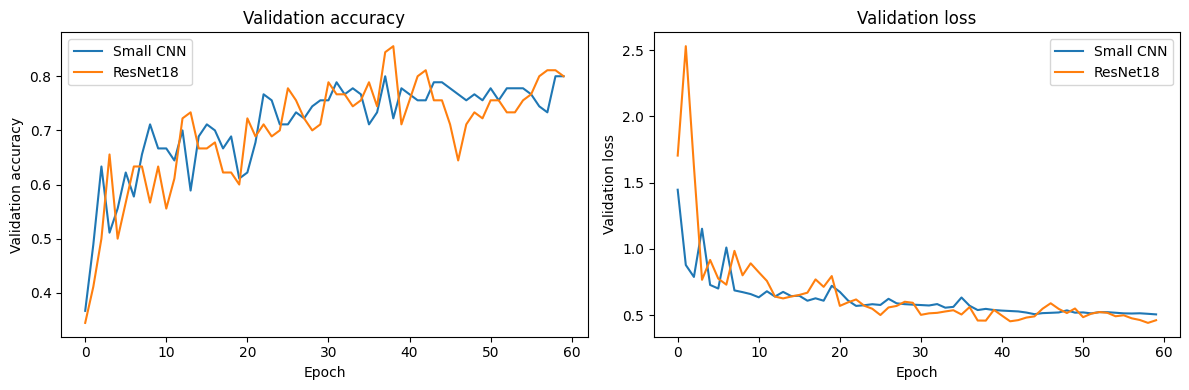


--- Summary ---
Small CNN  best val accuracy: 0.8000
ResNet18   best val accuracy: 0.8556


In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_cnn["val_acc"], label="Small CNN")
axes[0].plot(history_resnet["val_acc"], label="ResNet18")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Validation accuracy")
axes[0].legend()
axes[0].set_title("Validation accuracy")
axes[1].plot(history_cnn["val_loss"], label="Small CNN")
axes[1].plot(history_resnet["val_loss"], label="ResNet18")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation loss")
axes[1].legend()
axes[1].set_title("Validation loss")
plt.tight_layout()
plt.show()

print("\n--- Summary ---")
print(f"Small CNN  best val accuracy: {best_val_acc_cnn:.4f}")
print(f"ResNet18   best val accuracy: {best_val_acc_resnet:.4f}")

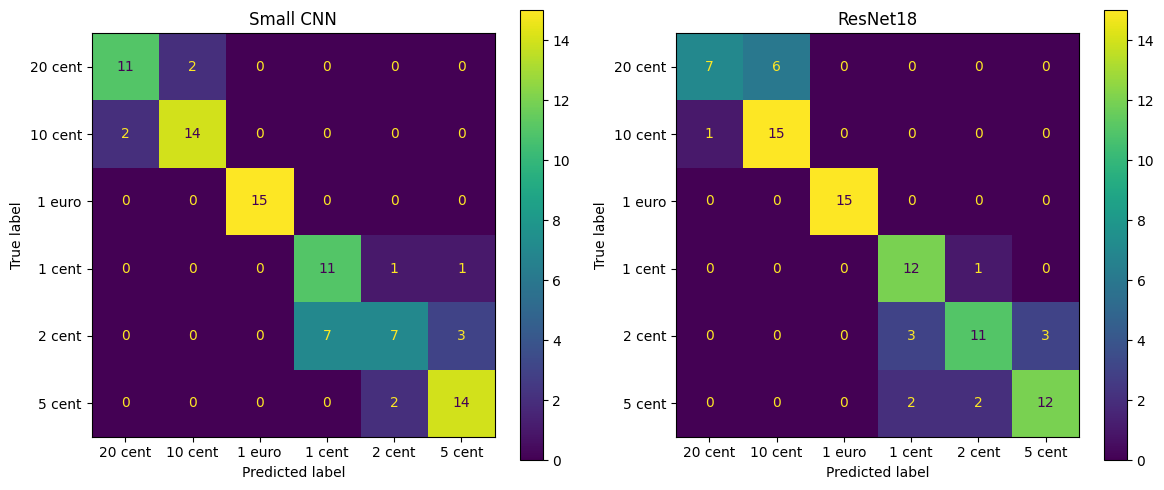

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for x, y in loader:
        x = x.to(device)
        pred = model(x).argmax(dim=1).cpu().numpy()
        all_pred.extend(pred)
        all_true.extend(y.numpy())
    return np.array(all_true), np.array(all_pred)

y_true, y_pred_cnn = get_predictions(model_cnn, val_loader, device)
y_true, y_pred_resnet = get_predictions(model_resnet, val_loader, device)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_cnn), display_labels=CLASS_NAMES).plot(ax=axes[0])
axes[0].set_title("Small CNN")
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_resnet), display_labels=CLASS_NAMES).plot(ax=axes[1])
axes[1].set_title("ResNet18")
plt.tight_layout()
plt.show()

In [36]:
torch.save({"model_state": model_cnn.state_dict(), "class_names": CLASS_NAMES}, "coin_cnn.pt")
torch.save({"model_state": model_resnet.state_dict(), "class_names": CLASS_NAMES}, "coin_resnet18.pt")